In [1]:
import spacy
import re
from nltk import word_tokenize

def matching_curly_braces(text):
    """return True if text has matching curly braces
    in the right order. Otherwise, returns False."""
    stack = []
    for c in text:
        if c == '{':
            stack.append(c)
        elif c == '}':
            if not stack or (c == '}' and stack[-1] != '{'):
                break
            stack.pop()
    return not stack


def remove_curly_braces(text):
    """remove all characters enclosed in curly braces from text"""
    left_bracket = []
    right_bracket = []
    stack = []
    for i, c in enumerate(text):
        if c == '{':  # c is curly brace
            stack.append(c)
            left_bracket.append(i)
        elif c == '}':           # c is closed curly brace
            # string is not valid
            if not stack or \
                (c == '}' and stack[-1] != '{'):
                break
            stack.pop() # pop open curly brace
            right_bracket.append(i+1)
    for _ in range(len(left_bracket)):
        shift = 0
        left_index = 0
        right_index = 0
        for left_index in range(len(left_bracket)):
            if left_bracket[left_index] > right_bracket[right_index]:
                left_index -= 1
                break
        text = text[0:left_bracket[left_index]] + text[right_bracket[right_index]:]
        shift = right_bracket[right_index] - left_bracket[left_index]
        for n in range(len(left_bracket)):
            if right_bracket[n] > right_bracket[right_index]:
                right_bracket[n] -= shift 
            if left_bracket[n] > left_bracket[left_index]:
                left_bracket[n] -= shift 
        left_bracket.pop(left_index)
        right_bracket.pop(right_index)
    return text

def remove_smart_quotes(text):
    """remove quotes in text"""
    return text.replace("“", "\"").replace("”","\"")

def clean_data(input_name, output_name):
    # read input file
    if input_name != "data.txt":
        with open(input_name, "r", encoding="utf8") as input_file:
            text = input_file.readlines()
            alt_text = ""
            for line in text:
                alt_text += line + "\n"
            if matching_curly_braces(alt_text):
                # remove text enclosed in curly_braces to remove random html code
                alt_text = remove_curly_braces(alt_text)
                text = alt_text
    else:
        with open(input_name, "r") as input_file:
            text = input_file.readlines()
            alt_text = ""
            for line in text:
                alt_text += line + "\n"
            if matching_curly_braces(alt_text):
                # remove text enclosed in curly_braces to remove random html code
                alt_text = remove_curly_braces(alt_text)
                text = alt_text

    text = re.sub("U.S.", "United States ", text)
    text = re.sub("p.m.", "pm ", text)
    text = re.sub("a.m.", "am ", text)
    text = re.sub("E.A.T.", "eat ", text)
    text = re.sub("-", " ", text)
    text = re.sub(r'([A-Za-z])(\d)', r'\1 \2', text)
    text = re.sub(r'(\d)([A-Za-z])', r'\1 \2', text)
    text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)

    nlp = spacy.load('en_core_web_sm')

    # split text into lines based on if it has a period, question, exclamation, or newline character
    text = re.split(r'[.?!]|\\n', text)

    # set list of stopwords
    stopwords = nlp.Defaults.stop_words
    html_stopwords = ["var","https", "csrftoken", "userdata", "csmllty54qx20erutnfcgs839jd2y", "const", "saml","getitem", "firebaseat", "firebaseapp", "json"]
    stopwords.update(html_stopwords)
    # write to output file
    with open(output_name, "w") as output_file:
        for line in text:
            # remove punctuation and stopwords from line
            tokenized_line = [word.lower() for word in word_tokenize(line) if word.isalnum() and word.lower() not in stopwords]
            newline = ""
            for word in tokenized_line:
                newline += word + " "
            if newline.strip():
                output_file.write(newline.strip() + "\n")

clean_data("data.txt", "cleaned_data.txt")

In [2]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from sklearn.model_selection import train_test_split
sentences = []  # this column has all of the sentences in the dataset
categories = []  # this column will have a 1 if it contains a question word, 0 otherwise
labels = [0, 1]
with open("cleaned_data.txt", "r") as file:
    sentences = file.readlines()
for sent in sentences:
    categories.append(0)
    for word in ["school", "student", "graduate", "learn", "class", "university"]:
        if word in sent:
            categories.pop()
            categories.append(1)
            break
sentences_train, sentences_test, sentiment_train, sentiment_test = train_test_split(sentences,
categories,test_size = 0.2,random_state = 42)

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

# min_df is the minimum proportion of documents that contain the word (excludes words that
# are rarer than this proportion)
# max_df is the maximum proportion of documents that contain the word (excludes words that
# are rarer than this proportion
# max_features is the maximum number of words that will be considered
# the documents will be lowercased
vectorizer = CountVectorizer(min_df = 0.0, max_df = 1.0, max_features = 10, lowercase = True)

vectorizer.fit(sentences_train)
vectorizer.fit(sentences_test)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

In [4]:
from keras.models import Sequential
from keras import layers
from keras import models

# Number of features (words)
# This is based on the data and the parameters that were provided to the vectorizer
# min_df, max_df and max_features
input_dimension = X_train.shape[1]  
print(input_dimension)

# a Sequential model is a stack of layers where each layer has one input and one output
# tensor
# Since this is a binary classification problem, there will be one output (0 or 1) 
# depending on whether the sentence is related to education or not
# so Sequential is appropriate
model = Sequential()
model.add(layers.Dense(16, input_dim = input_dimension, activation = 'relu'))
model.add(layers.Dense(16, activation = 'relu'))
# output layer
model.add(layers.Dense(1, activation = 'sigmoid'))

10


In [5]:
model.compile(loss = 'binary_crossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy'])
# summarize the model to make sure that it's structured as intended
model_summary = model.summary()
with open("neural_network_model.json", "w") as output_file:
    output_file.write(model.to_json())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                176       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 


Total params: 465 (1.82 KB)
Trainable params: 465 (1.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
import numpy
sentiment_train = numpy.array(sentiment_train)
sentiment_test = numpy.array(sentiment_test)
history = model.fit(X_train, numpy.array(sentiment_train),
                    epochs=30,
                    verbose=True,
                    validation_data=(X_test, numpy.array(sentiment_test)),
                    batch_size=20)


Epoch 1/30
30/30 [==============================] - 1s 11ms/step - loss: 0.6667 - accuracy: 0.7323 - val_loss: 0.6221 - val_accuracy: 0.9128
Epoch 2/30
30/30 [==============================] - 0s 3ms/step - loss: 0.5980 - accuracy: 0.8788 - val_loss: 0.5589 - val_accuracy: 0.8792
Epoch 3/30
30/30 [==============================] - 0s 3ms/step - loss: 0.5419 - accuracy: 0.8771 - val_loss: 0.5066 - val_accuracy: 0.8792
Epoch 4/30
30/30 [==============================] - 0s 3ms/step - loss: 0.4920 - accuracy: 0.8872 - val_loss: 0.4572 - val_accuracy: 0.8926
Epoch 5/30
30/30 [==============================] - 0s 3ms/step - loss: 0.4438 - accuracy: 0.9074 - val_loss: 0.4093 - val_accuracy: 0.9195
Epoch 6/30
30/30 [==============================] - 0s 4ms/step - loss: 0.3978 - accuracy: 0.9242 - val_loss: 0.3644 - val_accuracy: 0.9195
Epoch 7/30
30/30 [==============================] - 0s 4ms/step - loss: 0.3564 - accuracy: 0.9259 - val_loss: 0.3214 - val_accuracy: 0.9195
Epoch 8/30
30/30 [=

In [7]:
from keras.backend import clear_session
# clear states generated by Keras to reduce memory usage
clear_session()

In [8]:
with open("neural_network_accuracy.txt", "w") as output_file:
    loss, accuracy = model.evaluate(X_train, sentiment_train, verbose=False)
    print("Training Accuracy: {:.4f}".format(accuracy))
    output_file.write("Training Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(X_test, sentiment_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))
    output_file.write("\nTraining Accuracy: {:.4f}".format(accuracy))


Training Accuracy: 0.9428
Testing Accuracy:  0.9262


In [9]:
#%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label = 'Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(fontsize = 14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    #plt.savefig('acc.svg')
    #plt.show()
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend(fontsize = 14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('loss.svg')
    plt.show()
   

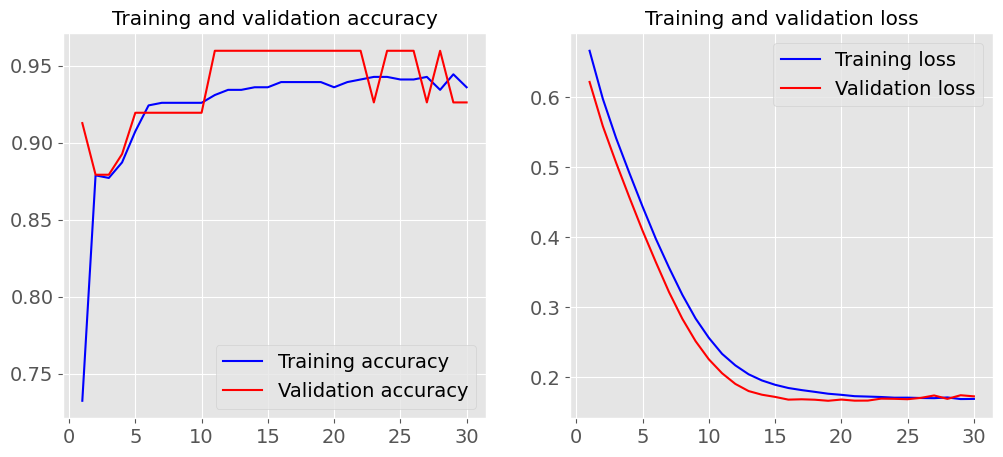

In [10]:
plot_history(history)

In [11]:
# For this dataset, it seems that using a softmax activation function instead of a relu activation allows for a slightly better testing accuracy
# However, the difference between the two when using several hidden layers seems to be negligible
# Increasing the number of epochs seems to make the neural network achieve better accuracy up to a certain point
# (sometimes the neural network may have lower accuracy in the beginning, but the accuracy seems to increase towards the end)
# Using at least 1 or more hidden layers seems to be good enough to achieve a good accuracy (> 90%)
# Adding more hidden layers does not seem to increase accuracy of the neural network accordingly
# Sometimes, a certain combination of softmax and relu hidden layers can cause the accuracy of the overall network to decrease drastically
# Altering the test_size from 0.2 (either higher or lower) seems to cause negative effects on accuracy of the neural network
# It is possible that more data is needed in the dataset to help increase the size of the training/test data so that the neural network can be made more accurate